In [1]:
import pandas as pd
import scipy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import seaborn as sns
import re
plt.style.use('ggplot')

In [3]:
cars = pd.read_csv("data/cars.csv")

# Cleaning and EDA

In [4]:
# Strip the strs
cars["drive"] = cars["drive"].str.strip()
cars["title"] = cars["title"].str.strip()
cars["exter"] = cars["exter"].str.strip()
cars["inter"] = cars["inter"].str.strip()
cars["made"] = cars["made"].str.strip()
cars["model"] = cars["model"].str.strip()
cars["eng"] = cars["eng"].str.strip()
cars["tran"] = cars["tran"].str.strip()
cars["mileage"] = cars["mileage"].str.strip()

In [5]:
# Clean Price and mileage column
cars["price"].replace(["Not Priced","FWD"], None, inplace = True)
cars["price"].replace({'\$': '', ',': ''}, regex=True, inplace = True)
cars["mileage"].replace({',': ''}, regex=True, inplace = True)
cars["mileage"].replace("Not provided", np.NaN, inplace = True)
cars["price"].replace([None, 1], np.NaN, inplace = True)

In [6]:
# Remove NAs in price and mileage
cars["exter"].fillna("UNKNOW", inplace = True)
cars.dropna(subset = ["price"],inplace = True)
cars.dropna(subset = ["mileage"],inplace = True)
cars.isna().sum()

cty         8295
drive       3381
eng         1742
exter          0
fuel           0
hwy         8295
inter       5519
made           0
mileage        0
model          0
price          0
slreview    4584
slrzip      1170
title          0
tran         992
year           0
dtype: int64

In [7]:
cars["mileage"] = cars["mileage"].astype(int)
cars["price"] = cars["price"].astype(int)

In [8]:
# Clean the drive column
cars["drive"].replace(["4MATIC", "quattro", "Quattro AWD", "Four Wheel Drive", "All Wheel Drive", 
                        "All-Wheel Drive with Locking Differential", "All-Wheel Drive with Locking and Limited-Slip Differential", 
                        "ALL-WHEEL DRIVE", "4x4/4-wheel drive", "Four-Wheel Drive with Locking and Limited-Slip Differential", 
                        "4x4", "4WD", "4MATICA?", "4MATIC AWD", "4MATIC 4WD", "FOUR-WHEEL DRIVE", "Four-Wheel",
                        "4x2","4X2", "4X4", "CVT 7-Speed", "All-wheel Drive"], "AWD", inplace = True)
cars["drive"].replace(["Front-wheel Drive", "FrontTrak", "FRONT-WHEEL DRIVE", "Front Wheel Drive", "2WD", "Unspecified",
                        "Front-Wheel Drive with Limited-Slip Differential", "Front-Wheel Drive"], "FWD", inplace = True)
cars["drive"].replace(["Rear-wheel Drive", "Rear-Wheel Drive with Limited-Slip Differential", "4x2/2-wheel drive", 
                        "Rear-Wheel Drive", "Rear Wheel Drive", "Automatic 8-Speed"], "RWD", inplace = True)
cars.groupby("drive")["title"].count().sort_values(ascending = False)

drive
AWD    30621
FWD    17807
RWD     4796
Name: title, dtype: int64

In [9]:
# Clean the exter column
cars.loc[cars["exter"].str.contains("White"), "exter"] = "White"
cars.loc[cars["exter"].str.contains("Black"), "exter"] = "Black"
cars.loc[cars["exter"].str.contains("Silver"), "exter"] = "Silver"
cars.loc[cars["exter"].str.contains("Blue"), "exter"] = "Blue"
cars.loc[cars["exter"].str.contains("Red"), "exter"] = "Red"
cars.loc[cars["exter"].str.contains("Gray"), "exter"] = "Gray"
cars.loc[cars["exter"].str.contains("Yellow"), "exter"] = "Yellow"
cars.loc[cars["exter"].str.contains("Brown"), "exter"] = "Brown"
cars.loc[cars["exter"].str.contains("Grey"), "exter"] = "Gray"

### Basica Plots

In [10]:
scatter_df = cars.loc[(cars["year"]>2000) & (cars["made"] == "Mercedes-Benz")]
scatter_df = scatter_df[["year", "price"]]

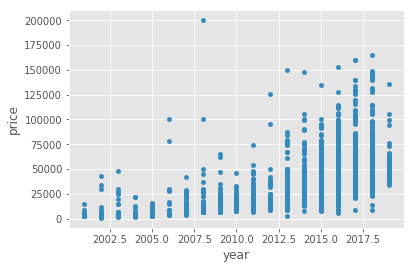

In [11]:
# Scatter between Price and year for Mercedes
scatter_df.plot.scatter(x = "year", y = "price")

In [12]:
# Scatter for Chevrolet
scatter_df1 = cars.loc[(cars["mileage"]<200000) & (cars["price"]<300000) & (cars["made"] == "Chevrolet")]
scatter_df1 = scatter_df1[["price", "mileage"]]

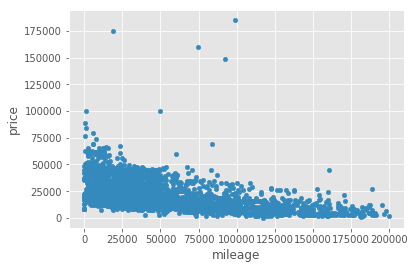

In [13]:
scatter_df1.plot.scatter(x = "mileage", y = "price")

Text(0.5, 1.0, 'Sample Size By Make')

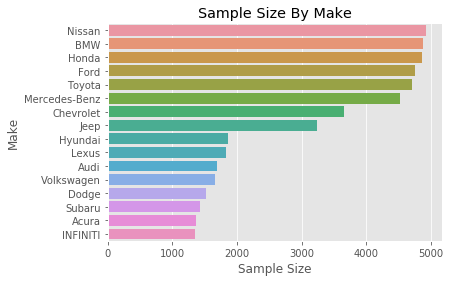

In [14]:
# Top 10 makes with the most sample size
maderank = cars.groupby("made")[["title"]].count().sort_values(by = "title",ascending = False)
samplesize = maderank.reset_index().head(16)
sns.barplot(x="title",y="made",data = samplesize)
plt.xlabel("Sample Size")
plt.ylabel("Make")
plt.title("Sample Size By Make")

In [17]:
# Keep recorders for cars after 2000
t10cars = cars.loc[cars["made"].isin(["Nissan","Honda", "BMW", "Ford", "Toyota", "Mercedes-Benz", "Chevrolet", "Jeep",
                           "Hyundai", "Lexus"]) & (cars["year"] > 2000)]
t10cars.shape

(38984, 16)

In [18]:
pricemean = t10cars.groupby("made")[["price"]].mean().sort_values(by="price", ascending = False)
pricemean.reset_index(inplace=True)
milemean = t10cars.groupby("made")[["mileage"]].mean().sort_values(by="mileage", ascending = False)
milemean.reset_index(inplace=True)

Text(0.5, 1.0, 'Average Price By Make')

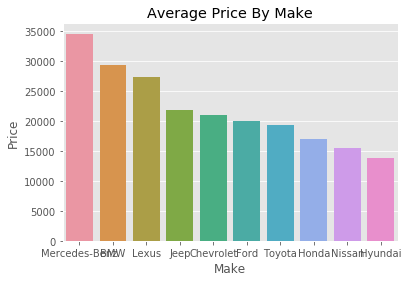

In [19]:
sns.barplot(x="made",y="price",data = pricemean)
plt.xlabel("Make")
plt.ylabel("Price")
plt.title("Average Price By Make")

Text(0.5, 1.0, 'Average Mileage By Make')

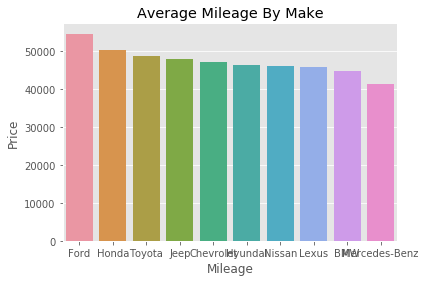

In [20]:
sns.barplot(x="made",y="mileage",data = milemean)
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Average Mileage By Make")

In [17]:
cars.loc[cars["year"]<2000].shape

(297, 16)

### Remove Outliers 

In [18]:
t10 = t10cars[t10cars.groupby("year").price.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
t10 = t10[t10.groupby("year").mileage.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]

In [183]:
t10.isna().sum()

cty         4370
drive       2125
eng          892
exter          0
fuel           0
hwy         4370
inter       3992
made           0
mileage        0
model          0
price          0
slreview    2929
slrzip       668
title          0
tran         429
year           0
age            0
dtype: int64

### General plots for top 10 brands. 

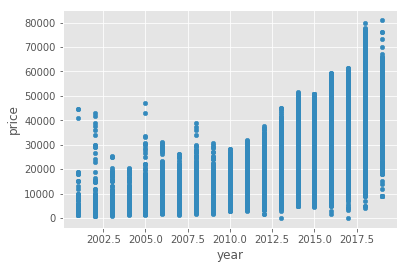

In [160]:
t10.plot.scatter(x = "year", y = "price")

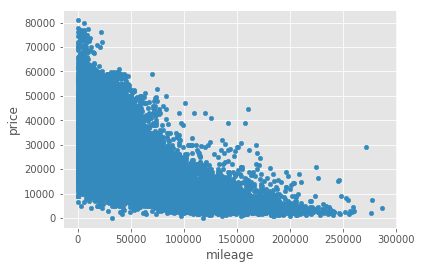

In [159]:
t10.plot.scatter(x = "mileage", y = "price")

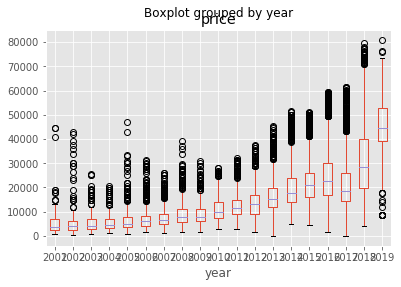

In [158]:
t10.boxplot(by = 'year', column = 'price')

In [19]:
to10 = t10.drop(t10.loc[t10["price"] == 1].index)

In [165]:
t10.to_csv("t102.csv",index=False)

In [692]:
t10.groupby("made")["title"].count().sort_values(ascending = False)

made
Nissan           4867
Honda            4833
BMW              4768
Toyota           4636
Ford             4588
Mercedes-Benz    4070
Chevrolet        3494
Jeep             3214
Hyundai          1864
Lexus            1803
Name: title, dtype: int64

In [20]:
t10 = t10.assign(age = 2019 - t10["year"])

In [21]:
honda = t10.loc[t10["made"] == "Honda"][["age", "mileage", "price", "model", "exter"]]
honda.shape

(4810, 5)

In [22]:
honda = honda[honda.groupby("age").price.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
honda = honda[honda.groupby("age").mileage.transform(lambda x: np.abs(x-x.mean())/x.std() < 3)]
honda.shape

(4717, 5)

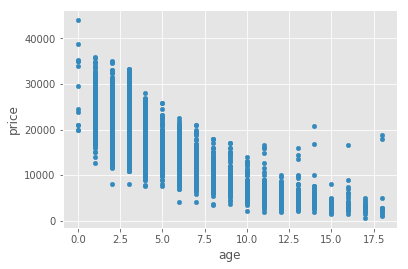

In [126]:
honda.plot.scatter(x = "age", y = "price")

## Linear regression attempt

In [23]:
X = honda.drop("price", axis = 1)
X =  X.assign(agesqrt = X.age**2)
X = pd.get_dummies(X)
y = honda["price"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [28]:
lm = linear_model.LinearRegression()

In [29]:
model = lm.fit(X_train,y_train)

In [30]:
model.score(X_test,y_test)

0.8286614803248618

In [138]:
y_pre = model.predict(X_train)

In [139]:
y_pre[0:5]

array([ 9538.5123868 , 20369.11972553, 21132.36617267, 18604.61400241,
        6135.02835442])

In [140]:
y_train[0:5]

15979     5995
15888    17995
183      13990
14756    16995
14940     6795
Name: price, dtype: int64

In [141]:
model.coef_

array([-2.20026296e+03, -5.01805685e-02, -2.65325455e+03, -1.07318353e+02,
       -4.57132335e+03, -4.05468772e+03,  1.52674941e+03,  1.15473732e+03,
        1.15301518e+03,  4.42094464e+02, -4.92858277e+03, -2.92723526e+03,
       -5.39458177e+03,  2.33642815e+03,  4.76073156e+03,  4.74080795e+03,
        8.52241973e+03,  7.71671645e+01])

In [231]:
model.coef_[1]

-0.05018056851693634

In [230]:
model.coef_[0] + model.coef_[-1]

-2200.2629552294566

In [167]:
model.intercept_

28306.946543350023

In [144]:
RMSE = np.sqrt(mean_squared_error(y_train, y_pre))
RMSE

2677.6935890076024

In [ ]:
import statsmodels.api as sm

In [338]:
mmake = t10["made"] == "BMW"
mmodel = t10["model"] == "X5"
mexter = t10["exter"].isin(["Black", "Gray", "Silver", "White", "Blue", "Red"])
X2 = t10.loc[mmake&mmodel&mexter][["age", "mileage", "price", "exter"]].drop("price", axis = 1)
y2 = t10.loc[mmake&mmodel&mexter]["price"]

In [339]:
X2.groupby("exter")["mileage"].count()

exter
Black     266
Blue       65
Gray       99
Red         6
Silver     69
White     181
Name: mileage, dtype: int64

In [331]:
X2 = pd.get_dummies(X2)

In [332]:
model = sm.OLS(y2,X2).fit()

In [333]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     424.0
Date:                Mon, 11 Feb 2019   Prob (F-statistic):          8.31e-243
Time:                        22:45:24   Log-Likelihood:                -6927.9
No. Observations:                 686   AIC:                         1.387e+04
Df Residuals:                     678   BIC:                         1.391e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
age          -2157.9018    146.272    -14.753      0.000   -2445.103   -1870.700
mileage         -0.2265      0.013    -16.973      0.000      -0.253      -0.200
exter_Black   5.403e+04    516.601    104.590      0.000     5.3e+04     5.5e+04
exter_Blue    5.395e+04    824.530     65.428      0.000    5.23e+04    5.56e+04
exter_Gray    5.277e+04    742.620     71.059      0.000    5.13e+04    5.42e+04
exter_Red     5.545e+04   2529.158     21.924      0.000    5.05e+04    6.04e+04
exter_Silver  5.277e+04    811.120     65.055      0.000    5.12e+04    5.44e+04
exter_White   5.311e+04    563.706     94.212      0.000     5.2e+04    5.42e+04
==============================================================================
Omnibus:                      179.925   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              518.133
Skew:                           1.284   Prob(JB):                    3.08e-113
Kurtosis:                       6.395   Cond. No.                     6.41e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [334]:
model.params.sort_values(ascending = False)

exter_Red       55448.674875
exter_Black     54031.467604
exter_Blue      53947.020206
exter_White     53107.832909
exter_Gray      52770.089981
exter_Silver    52767.417055
mileage            -0.226528
age             -2157.901757
dtype: float64